In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

In [3]:
# imports
import tensorflow as tf
import keras.layers as layers
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from utils import plot_history
import re
import string
import numpy as np
import pandas as pd

In [123]:
# experiment name
name = 'both_generated_using_correct_names_40k'

# Dataset

In [124]:
df = pd.read_csv(f"data/{name}.csv")
print(df.shape)
df.sample(10)

(40000, 2)


,Name,class
22279,اظمن دحادعمس داعبهملىد,0.0
33292,رروضه مستر لقضية,0.0
9488,ملك قدريه زكريا,1.0
12654,قلدس زعبله نبهان,1.0
30178,ومتعاونين قعدة دهشة,0.0
9058,جهاد اميل محمدعوض,1.0
30425,اهتماما بنظام أجنبي,0.0
39609,شاكرر دنيال الحاج,0.0
12740,شابينام سلوان منصور,1.0
17841,نحمده غياظ عبود,1.0


In [125]:
# max number of words per name
df['Name'].str.split().str.len().max()

3

In [126]:
df.head(5)

,Name,class
0,ميلار الليل بلاسى,1.0
1,الغالى لبا بركات,1.0
2,عبداالمتجلى السيدالسعيد رينادا,1.0
3,ونيس سعا عبدالروف,1.0
4,محمدحسن عاليا عليه,1.0


In [127]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Name,class
0,امنيه قدرى مطيع,1.0
1,الكومى ياسرابراهيم حرمى,1.0
2,تنمو طبيعيه يرحمك,0.0
3,الفضضالى دشنةه اامدىلن,0.0
4,نداء شبان الكيلانى,1.0


## Document Preprocessing

In [128]:
# adding start and end tokens
names = ['<SOS> ' + x + ' <EOS>' for x in df['Name'].tolist()]
corpus = " ".join(names)
labels = df['class'].tolist()
corpus[:1000]

'<SOS> امنيه قدرى مطيع <EOS> <SOS> الكومى ياسرابراهيم حرمى <EOS> <SOS> تنمو طبيعيه يرحمك <EOS> <SOS> الفضضالى دشنةه اامدىلن <EOS> <SOS> نداء شبان الكيلانى <EOS> <SOS> محمل ميانح للاقامة <EOS> <SOS> الووففائئى العبباسى السعدونىى <EOS> <SOS> سيلم اباظه هالة <EOS> <SOS> استراحة سياسى تنفذ <EOS> <SOS> الررااعىى رروناا رشادد <EOS> <SOS> تومااس زاالل تراث <EOS> <SOS> مضر اسمى العمرى <EOS> <SOS> تكرييمم سونه محدى <EOS> <SOS> أحكم منتج الاستخدام <EOS> <SOS> الرحله الحملة وكعادة <EOS> <SOS> ششهير هالة مرريياان <EOS> <SOS> وكثيرا علينادبى نجلة <EOS> <SOS> يدق قصائده ممهين <EOS> <SOS> ديحمو اصلقىد عنوودد <EOS> <SOS> عزايم وحيد عوضين <EOS> <SOS> قدرية ايلين السعيدعارف <EOS> <SOS> ست المنصصورى ععبدااللهى <EOS> <SOS> لضف مياده االمداحح <EOS> <SOS> راضى جواهر امام <EOS> <SOS> خيرات سهيله الجارحى <EOS> <SOS> اشد ححممتوو ععبددالغفارععلى <EOS> <SOS> المسؤولين ينقطع يشك <EOS> <SOS> حندوق طيبه بهزار <EOS> <SOS> محود الصباح مسلمى <EOS> <SOS> قاسم لوسى روايدا <EOS> <SOS> رؤال حسام الفرماوى <EOS> <SOS> ييددف

## Tokenization 

In [129]:
tokenize = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', lower=False)
tokenize.fit_on_texts(names)
X = tokenize.texts_to_sequences(names)
max_len = 6
X = tf.keras.utils.pad_sequences(X, maxlen=max_len, padding='post')
total_words = len(tokenize.word_index)+1
print(f"Total Words: {total_words}")
print("Example of a Sequence")
print(X[:3])
print("Some Tokens")
print(list(tokenize.word_index)[:10])

Total Words: 14782
Example of a Sequence
[[    2   310    73  1375     3     0]
 [    2  1376  1117  2837     3     0]
 [    2  6734  4581 12696     3     0]]
Some Tokens
['<UNK>', '<SOS>', '<EOS>', 'جميلة', 'ختام', 'فاضل', 'خاطر', 'سنا', 'العز', 'صفوه']


## Splitting data and making dataset 

In [130]:
x_train, x_valid, y_train, y_valid = train_test_split(X, df['class'].values, test_size=.2, random_state=23)
print("Train and Validation sizes")
len(x_train), len(x_valid), len(y_train), len(y_valid)

Train and Validation sizes


(32000, 8000, 32000, 8000)

In [131]:
# number of possitive examples, should be near half its split 
y_train.sum(), y_valid.sum()

(16001.0, 3999.0)

In [132]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(128)

In [133]:
for x,y in ds_train.take(1):
    print(x[:2], y[:2])

tf.Tensor(
[[   2  966 4017  623    3    0]
 [   2 7632 5129  537    3    0]], shape=(2, 6), dtype=int32) tf.Tensor([0. 0.], shape=(2,), dtype=float64)


# Build and Train a Model: 

In [134]:
vocab_size = total_words
embedding_dim = 16
sequence_length = max_len
rnn_units = 16

In [135]:
def get_model(summary=True):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        tf.keras.layers.Dropout(.4),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units)),
        tf.keras.layers.Dropout(.4),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(.4),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=tf.metrics.BinaryAccuracy())

    if summary:
        model.summary()
    return model
model=get_model()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 16)          236512    
                                                                 
 dropout_24 (Dropout)        (None, None, 16)          0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 32)               4224      
 onal)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                     

In [136]:
epochs = 10
early_stopping = EarlyStopping(patience=6, restore_best_weights=True, verbose=True)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/10
250/250 [==============================] - 4s 7ms/step - loss: 0.4947 - binary_accuracy: 0.6796 - val_loss: 0.1535 - val_binary_accuracy: 0.9450
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1141 - binary_accuracy: 0.9598 - val_loss: 0.1051 - val_binary_accuracy: 0.9647
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0697 - binary_accuracy: 0.9772 - val_loss: 0.0930 - val_binary_accuracy: 0.9693
Epoch 4/10
250/250 [==============================] - 1s 6ms/step - loss: 0.0516 - binary_accuracy: 0.9837 - val_loss: 0.1144 - val_binary_accuracy: 0.9655
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0431 - binary_accuracy: 0.9877 - val_loss: 0.1089 - val_binary_accuracy: 0.9669
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0362 - binary_accuracy: 0.9894 - val_loss: 0.1220 - val_binary_accuracy: 0.9657
Epoch 7/10
250/250 [==============================] - 1s 6ms/ste

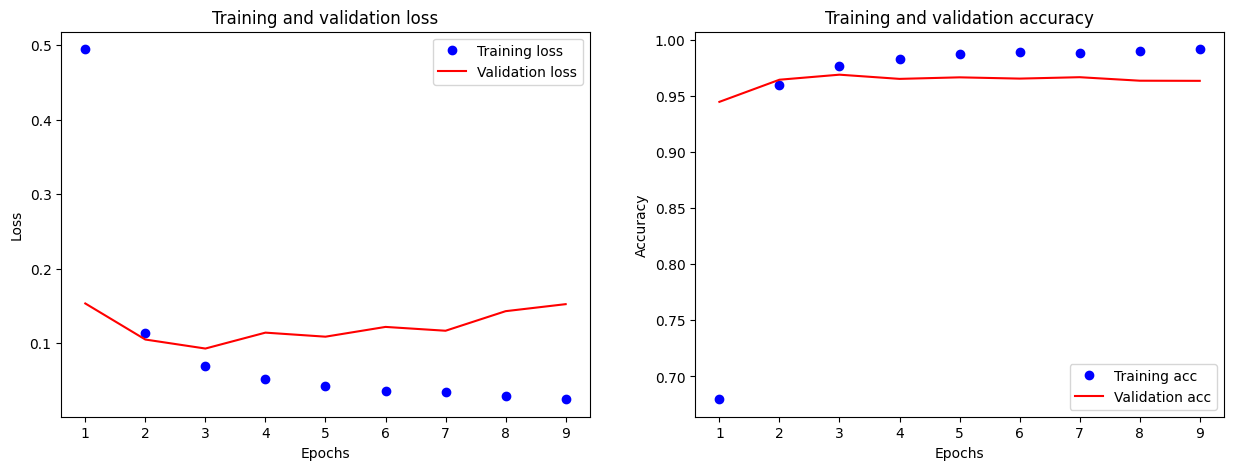

In [137]:
plot_history(history.history)

### Test Examples 

In [138]:
#new
example = '<sos> ' + "معاذ طه عوض" + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 453ms/step


array([[0.8750806]], dtype=float32)

In [139]:
#new
example = "باسم وحيد السيد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 48ms/step


array([[0.98744917]], dtype=float32)

In [140]:
#new
example = "شسي شسي شسي"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 36ms/step


array([[0.00569531]], dtype=float32)

In [141]:
#new
example = "باسمم وحةد السد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.00072087]], dtype=float32)

In [142]:
#new
example = "مريم محمد محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 34ms/step


array([[0.9931457]], dtype=float32)

In [143]:
#new
example = "محمد مريم محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 35ms/step


array([[0.99442357]], dtype=float32)

In [144]:
#new
example = "مريم محمد على"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 34ms/step


array([[0.9963276]], dtype=float32)

In [145]:
#new
example = "محمد طه عوض"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.98151255]], dtype=float32)

In [146]:
#new
example = "زيادد عبدالرحمنت محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 37ms/step


array([[0.49426824]], dtype=float32)

In [147]:
#new
example = "دزيادد محمد سشيبسيب "
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 35ms/step


array([[0.5809362]], dtype=float32)

In [148]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 460ms/step


array([[0.9984516]], dtype=float32)

# Saving and loading the trained model 

In [149]:
model.save(f'models/{name}_lstm_16_dropout4_model.h5')

In [150]:
new_model = tf.keras.models.load_model(f'models/{name}_lstm_16_dropout4_model.h5')
new_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 16)          236512    
                                                                 
 dropout_24 (Dropout)        (None, None, 16)          0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 32)               4224      
 onal)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                     

## Saving and loading the tokenizer

In [151]:
import pickle

# saving
with open(f'models/{name}tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open(f'models/{name}tokenizer.pickle', 'rb') as handle:
    new_tokenizer = pickle.load(handle)

In [152]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 452ms/step


array([[0.9984516]], dtype=float32)

In [153]:
#new
example = "دزيادد محمد سشيبسيب "
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 1s 763ms/step


array([[0.5809362]], dtype=float32)

In [154]:
#new
example = "زيادد عبدالرحمنت محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 33ms/step


array([[0.49426824]], dtype=float32)

30000 10000 30000 10000
Epoch 1/10
235/235 [==============================] - 4s 8ms/step - loss: 0.5336 - binary_accuracy: 0.6446 - val_loss: 0.1520 - val_binary_accuracy: 0.9465
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.1246 - binary_accuracy: 0.9557 - val_loss: 0.1274 - val_binary_accuracy: 0.9581
Epoch 3/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0712 - binary_accuracy: 0.9761 - val_loss: 0.1255 - val_binary_accuracy: 0.9615
Epoch 4/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0496 - binary_accuracy: 0.9844 - val_loss: 0.1650 - val_binary_accuracy: 0.9571
Epoch 5/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0386 - binary_accuracy: 0.9884 - val_loss: 0.1329 - val_binary_accuracy: 0.9658
Epoch 6/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0333 - binary_accuracy: 0.9899 - val_loss: 0.1153 - val_binary_accuracy: 0.9678
Epoch 7/10
235/235 [====================

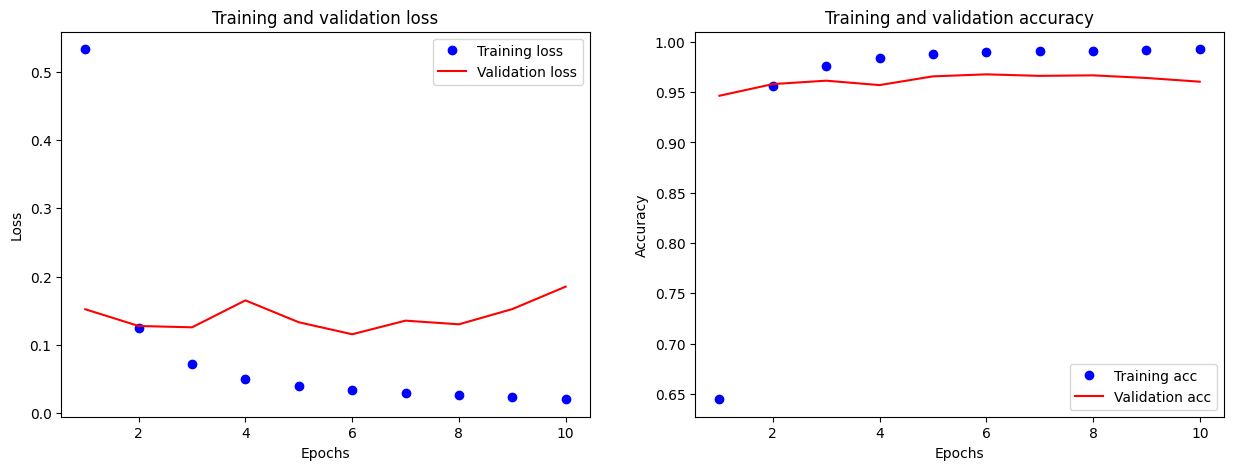

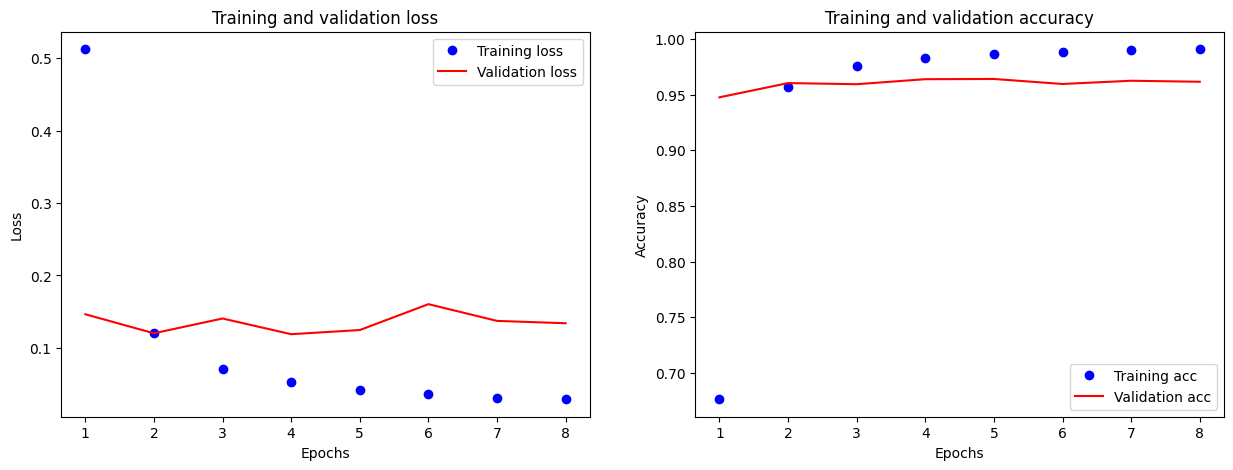

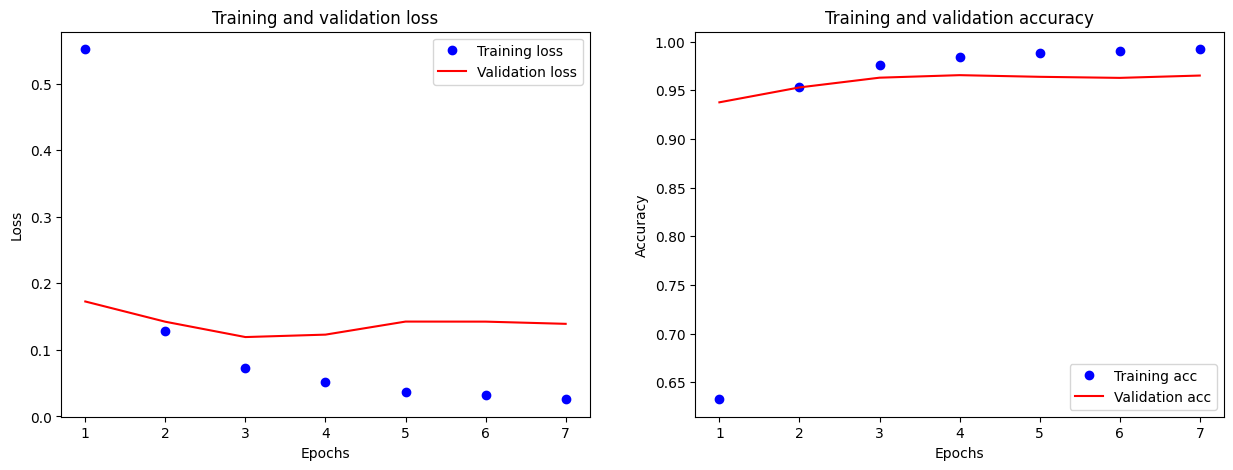

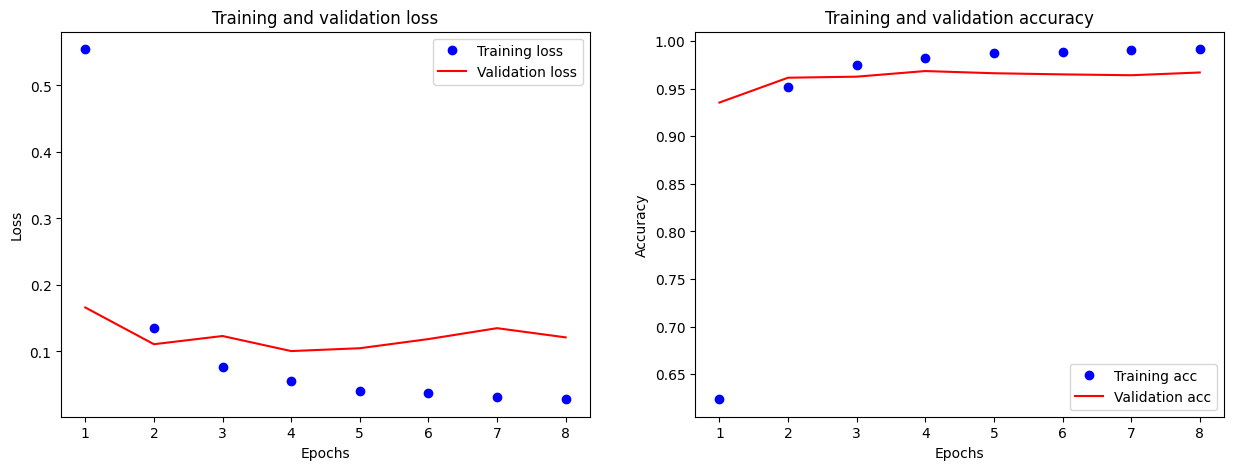

In [155]:
from sklearn.model_selection import KFold

early_stopping = EarlyStopping(patience=4, restore_best_weights=True, verbose=True)
epochs = 10

kfold = KFold(n_splits=4)

for train, valid in kfold.split(X):
    x_train, y_train = X[train], df['class'].values[train]
    x_valid, y_valid = X[valid], df['class'].values[valid]
    print(len(x_train), len(x_valid), len(y_train), len(y_valid))
    
    ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
    ds_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(128)
    
    model = get_model(False)
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=epochs,
        callbacks=[early_stopping])
    plot_history(history.history)